#Setup

**INSTALLATION**

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 wandb evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

**IMPORT LIBRARIES**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer,
    DataCollatorForLanguageModeling,
)
import wandb
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTTrainer
from evaluate import load
import torch.nn as nn

**Wandb Project**

In [ ]:
wandb.init(project="Zocket nlp intern task 1")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#Parameters

**Setting bitsandbytes parameters**

In [ ]:
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

**Setting base model parameters**

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "gpt2"

# The dataset to use
dataset_name = "PeterBrendan/Ads_Creative_Text_Programmatic"

# Fine-tuned model name
new_model = "gpt2-madhuzocket1"

**Setting LoRA parameters**

In [ ]:
# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

**Setting Train arguments**

In [ ]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 10

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

**Setting SFT parameters**

In [ ]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#Lora freezing, adaptors

**Load base model and tokenizer**

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Freeze original weights**

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

**Add lora adaptors, get peft config**

In [ ]:
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

trainable params: 2359296 || all params: 84331776 || trainable%: 2.7976358519948636


#Training

In [ ]:
# Load dataset
dataset = load_dataset(dataset_name, split="train")

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb",)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args= training_arguments,
    packing=packing,
)

model.config.use_cache = False
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,5.433800
50,6.153200
75,4.887300
100,5.136800
125,4.510800
150,4.969300
175,4.327000
200,4.721700
225,4.332800
250,4.811800


** SCREENSHOT OF LOSS CONVERGENCE OVER 10 EPOCHS (SMOOTHENING ENABLED)**



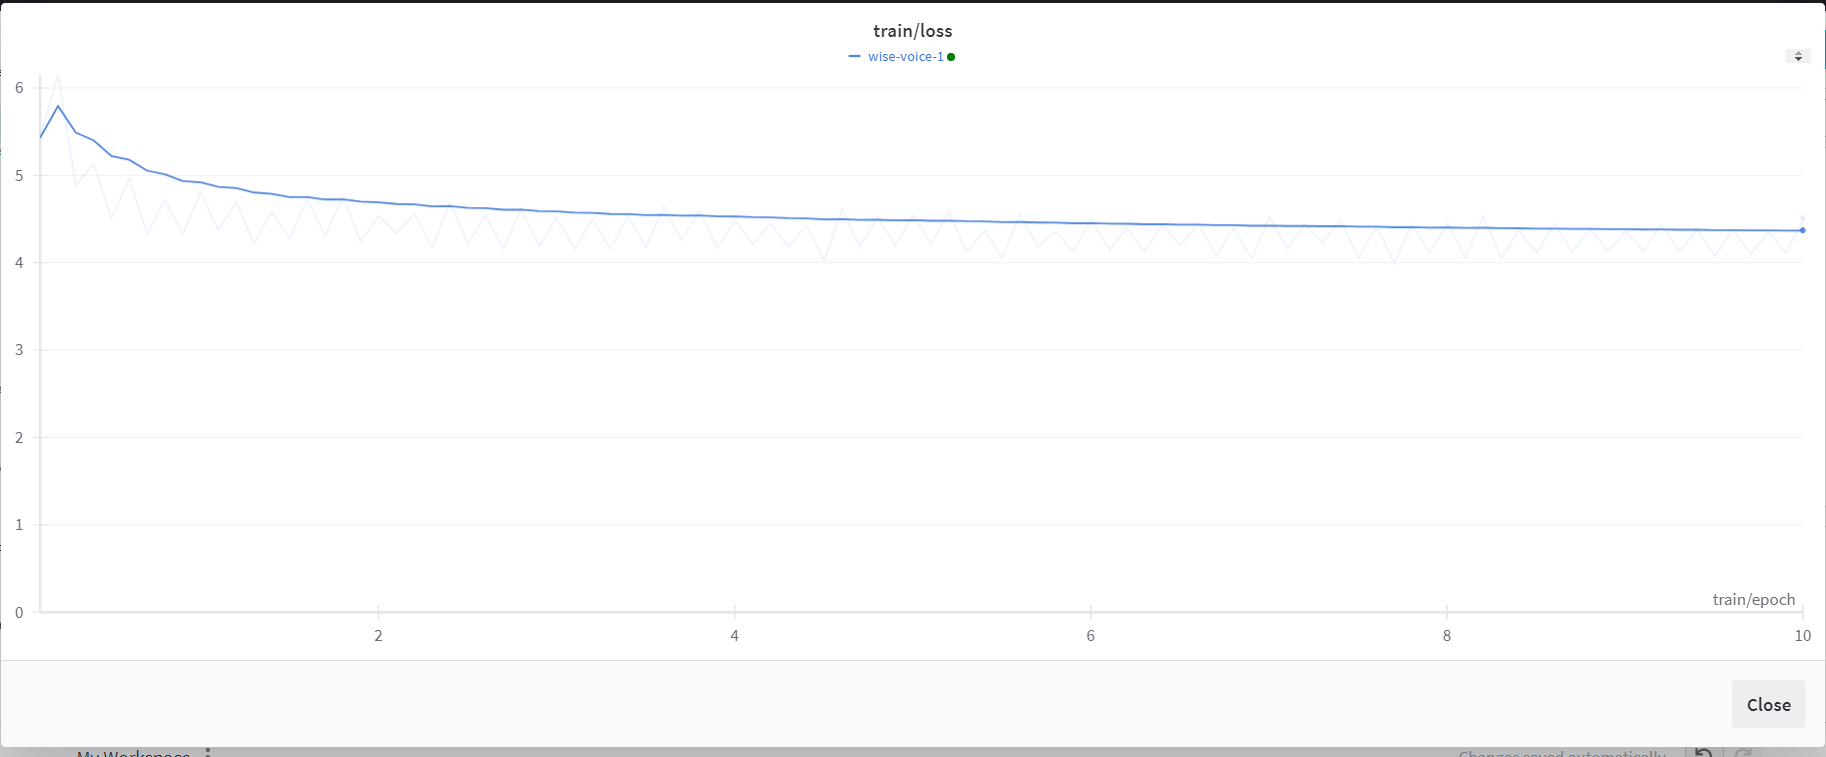

** SCREENSHOT OF LOSS CONVERGENCE OVER 10 EPOCHS (NO CURVE SMOOTHENING)**

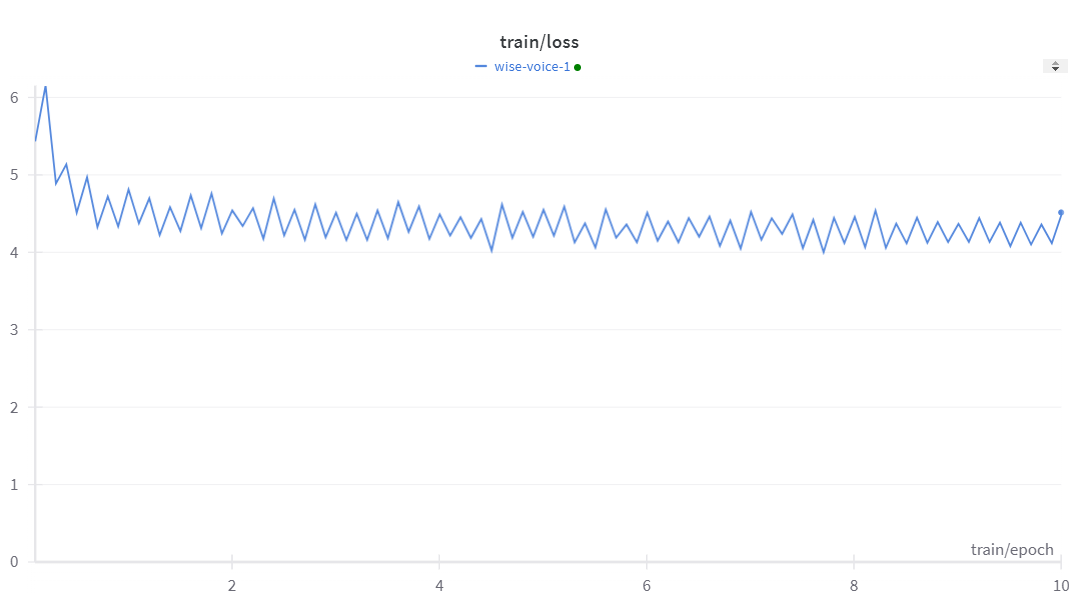

#Inference

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

In [ ]:
# Reload model in FP32 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float32,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
# Run text generation pipeline with new model
prompt = "Black friday sale is here"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)
result = pipe(f"<s>{prompt}")
print(result[0]['generated_text'])

<s>Black friday sale is here!
The First Half
Price £50
$25 $38.55 Available | 4pm CEST
Buy
FEDERAL REVENGE AND ASSOCIATION
LEARN MORE
GET FREE SHIPPING REIMBURSEMENT
GET A PLACE TO CALL HOME
JANUARY 2, 2014
7:00 AM, 9:00 AM
CEST
JANUARY 4
MARKET LIVE
1.25
2.00
1.50
2.55
2.75
3.00
3.65
4.00
5.15 * Free View In
SCHOOL
CORE MADE
EATING
IN YOUR SCHOOL
CORE
MADE IT IN YOUR STATE or TO YOUR CATEGORY:
SEPTEMBER 17, 2012
CERTIFICATIONAL CODESIA IN THE UNITED STATES
SCHEDULE 1.11
FEDERAL CODESIA CODE (1163.1) APPLICATION. PRIOR TO ORDER, IN ORDER TO ENTER YOUR STATE TO ENTER THE STATE OF COLORADO, AN EXPRESS OR IMPLIED APPLICATION HAS TO BE SUBJECT TO THE PERMANENT RULE AT UNLESS THE APPLICATION DIRECTS YOU THAT IN THE ANGRAMICATELY WRITTEN APPLICATION, YOU SHALL RECEIVE REPRESENTATIONS TO CERT-FOUNDATION-INFORMATIONAL CODESIA. AND SOON, SUCH REPRESENTATIONS SHALL NOT BE EFFECTIVE IN ANY OTHER CELERANTS, REGARDLESS OF IFSUED IN THE CERAMON CODE OF THE U.S.A. SECTION 1154.1(b)(5) OR BY ANY OTHER